<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sqlite3 import connect
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [3]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

In [4]:
data = pd.read_csv(folder_path + "olist_customer_cleaned_data.csv")

In [5]:
data.head()

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,last_purch,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,3,7787,top (Gold)
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,0,6053,risk (bronze)
2,0000f46a3911fa3c0805444483337064,536,1,86.22,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,4,88115,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,3,66812,inactive
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,1,18040,good (silver)


## La prévalence de la loyauté des clients

In [6]:
rfm_counts = data['rfm_segment_loyalty'].value_counts()

fig = px.pie(
    rfm_counts,
    values=rfm_counts.values,
    names=rfm_counts.index,
    title="Distribution des client par segment de Loyalty",
    hole=0
    )
fig.update_traces(textinfo="label+percent", textfont_size=12, rotation=90)
fig.update_layout(showlegend=True, legend_title_text="Segment de Loyalty")
fig.show()

In [27]:
pca_2d_dict =  {}
pca_3d_dict =  {}
tsne_2d = {}
tsne_3d = {}

def find_best_k(data):
  """
  Cette fonction permet d'estimer le meilleur k (nombre de cluster optimal) pour un dataset donné.
  data: dataframe
  return: silhouette_scores, dict_kmeans, best_silhouette_k
  """
  silhouette_scores = {}
  dict_kmeans = {}

  for k in range(2, 25):
      kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
      cluster_labels = kmeans.predict(data)
      silhouette_scores[k] = silhouette_score(data, cluster_labels)
      dict_kmeans[k] = kmeans

  best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
  print(f"best_k={best_silhouette_k}, best_silhouette_k={silhouette_scores[best_silhouette_k]}")
  return silhouette_scores, dict_kmeans, best_silhouette_k


def plot_silhouette_scores(data, silhouette_scores, best_silhouette_k):
  fig, axes = plt.subplots(1, 2, figsize=(18,5))

  axes[0].plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker="o", linestyle="-", label="Score de silhouette")
  axes[0].axvline(x=best_silhouette_k, color="r", linestyle="--", label=f"Meilleur silhouette à k={best_silhouette_k}")
  axes[0].set_xlabel("Nombre de clusters (k)")
  axes[0].set_ylabel("Silhouette Score")
  axes[0].set_xlabel("Nombre de clusters (k)")
  axes[0].set_ylabel("Silhouette Score")
  axes[0].set_title("Score de silhouette en fonction de k")
  axes[0].legend()


  visualizer = SilhouetteVisualizer(estimator=KMeans(random_state=42), k=(2, 25))

  visualizer.fit(data)    # Fit the data to the visualizer
  visualizer.poof(ax=axes[1])

  plt.show()

def plot_clusters(labels, X_pca=None, X_tsne=None):
  # Visualiser les résultats
  fig = plt.figure(figsize=(16, 8))

  cmap = mpl.colormaps.get_cmap('coolwarm')

  # Visualiser les résultats

  if X_pca is not None:
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='coolwarm', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with PCA 3D Visualization')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel("PC3")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

    ax1 = fig.add_subplot(2,2,3)
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm', s=50, alpha=0.6)
    ax1.set_title('K-means Clustering with PCA 2D Visualization')
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')

  if X_tsne is not None:
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels, cmap='coolwarm', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with t-SNE 3D Visualization')
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")
    ax.set_zlabel("t-SNE3")

    ax = fig.add_subplot(2,2,4)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='coolwarm', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with t-SNE 2D Visualization')
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")

  plt.show()


def get_pca(dim=2, selection='full', df=None):
  """
  dim: int => dimension de la projection
  selection: str => full ou rfm
  df: dataframe => dataframe à utiliser pour la projection
  return: X_pca
  """
  if selection == 'full':
    if dim == 2:
      if pca_2d_dict.get('full') is not None:
        return pca_2d_dict['full']
      pca = PCA(n_components=2)
      X_pca = pca.fit_transform(df)
      pca_2d_dict['full'] = (pca, X_pca)
      return (pca, X_pca)
    elif dim == 3:
      if pca_3d_dict.get('full') is not None:
        return pca_3d_dict['full']
      pca = PCA(n_components=3)
      X_pca = pca.fit_transform(df)
      pca_3d_dict['full'] = (pca, X_pca)
      return (pca, X_pca)
    else:
      raise ValueError("dim doit être 2 ou 3")
  else:
    if dim == 2:
      if pca_2d_dict.get(selection) is not None:
        return pca_2d_dict[selection]
      pca = PCA(n_components=2)
      X_pca = pca.fit_transform(df)
      pca_2d_dict[selection] = (pca, X_pca)
      return (pca, X_pca)
    elif dim == 3:
      if pca_3d_dict.get(selection) is not None:
        return pca_3d_dict[selection]
      pca = PCA(n_components=3)
      X_pca = pca.fit_transform(df)
      pca_3d_dict[selection] = (pca, X_pca)
      return (pca, X_pca)
    else:
      raise ValueError("dim doit être 2 ou 3")

# Standardisation des données

In [8]:
data_ = data.copy()
customer_unique_id = data.customer_unique_id
data_.drop(columns=['customer_unique_id', 'last_purch', 'rfm_segment_loyalty', 'customer_zip_code_prefix', 'last_purch_day_of_week'], inplace=True)
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(data_), columns=data_.columns)

In [9]:
X_scaled.head()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products
0,-0.825362,-0.15983,-0.122609,1.113386,1.320169,0.662443,-0.264706,-0.169129
1,-0.805701,-0.15983,-0.529564,-0.042962,1.302307,-0.095686,-0.264706,-0.169129
2,1.959998,-0.15983,-0.320144,-1.199310,-1.368063,-0.853816,-0.264706,-0.169129
3,0.544379,-0.15983,-0.471275,-1.199310,-0.483894,-0.095686,-0.264706,-0.169129
4,0.328104,-0.15983,0.072478,0.535212,-0.457101,0.662443,-0.264706,-0.169129


# 1 | K-Means Clustering

In [10]:
kmeans_data = X_scaled.sample(10000, random_state=42).copy()

In [11]:
kmeans_data.head()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products
21568,-0.196199,-0.15983,-0.495861,-0.621136,0.409207,0.662443,-0.264706,-0.169129
75457,-0.065123,-0.15983,-0.401563,-1.199310,-0.483894,0.662443,-0.264706,-0.169129
55143,-1.067853,-0.15983,-0.348916,0.535212,1.311238,0.662443,-0.264706,-0.169129
45829,0.387089,-0.15983,0.316523,0.535212,-0.457101,0.662443,-0.264706,-0.169129
33285,-1.421757,-0.15983,-0.321670,0.535212,1.311238,0.662443,-0.264706,-0.169129


In [58]:
kmeans_data.head()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products
21568,-0.196199,-0.15983,-0.495861,-0.621136,0.409207,0.662443,-0.264706,-0.169129
75457,-0.065123,-0.15983,-0.401563,-1.199310,-0.483894,0.662443,-0.264706,-0.169129
55143,-1.067853,-0.15983,-0.348916,0.535212,1.311238,0.662443,-0.264706,-0.169129
45829,0.387089,-0.15983,0.316523,0.535212,-0.457101,0.662443,-0.264706,-0.169129
33285,-1.421757,-0.15983,-0.321670,0.535212,1.311238,0.662443,-0.264706,-0.169129
...,...,...,...,...,...,...,...,...
56312,2.051751,-0.15983,-0.139496,-0.621136,-1.359132,0.662443,-0.264706,-0.169129
79648,-1.061299,-0.15983,1.189146,1.691560,1.329100,0.662443,-0.264706,-0.169129
48483,-0.261737,-0.15983,0.033560,0.535212,0.427069,0.662443,-0.264706,-0.169129
53688,-1.323450,-0.15983,-0.222405,1.113386,1.320169,-0.095686,-0.264706,-0.169129


## | 1.3 clustering avec les features rfm seulement

In [19]:
feats = ['recency', 'frequency', 'monetary', 'rfm_segment', 'satisfaction', 'rfm_score']
first_selection_df = kmeans_data[feats]

### 1.3.1 | recherche du k optimal

In [60]:
%%time
silhouette_scores, dict_kmeans, best_silhouette_k = find_best_k(first_selection_df)

best_k=4, best_silhouette_k=0.4134670010356209
CPU times: user 21.4 s, sys: 6.77 s, total: 28.2 s
Wall time: 22.9 s


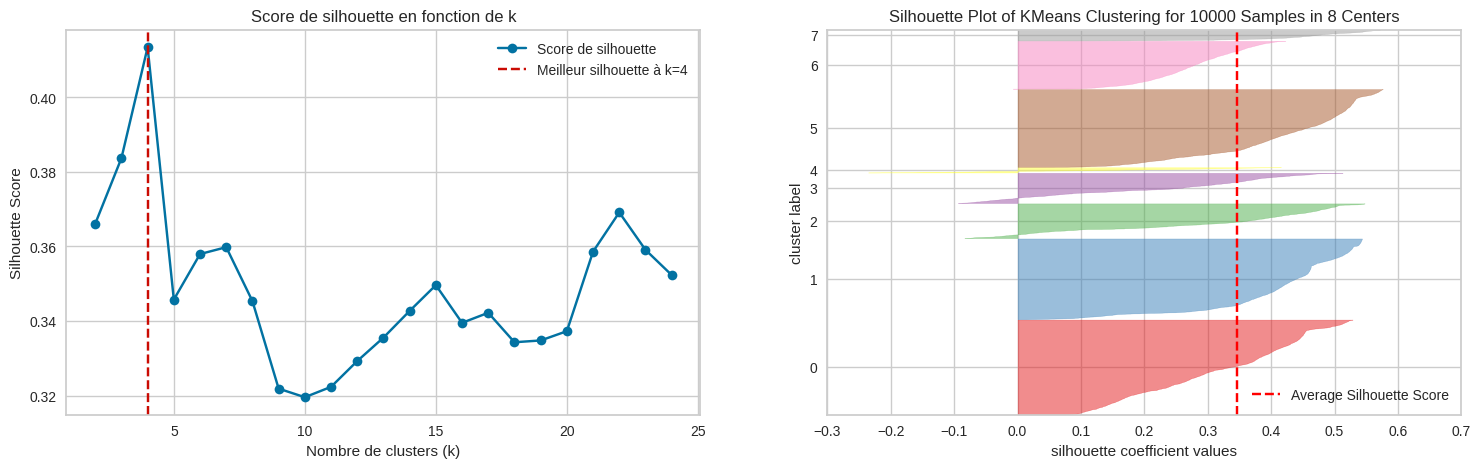

In [61]:
plot_silhouette_scores(first_selection_df, silhouette_scores, best_silhouette_k)

### 1.3.2 | Kmean avec  k=4

<timed exec>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



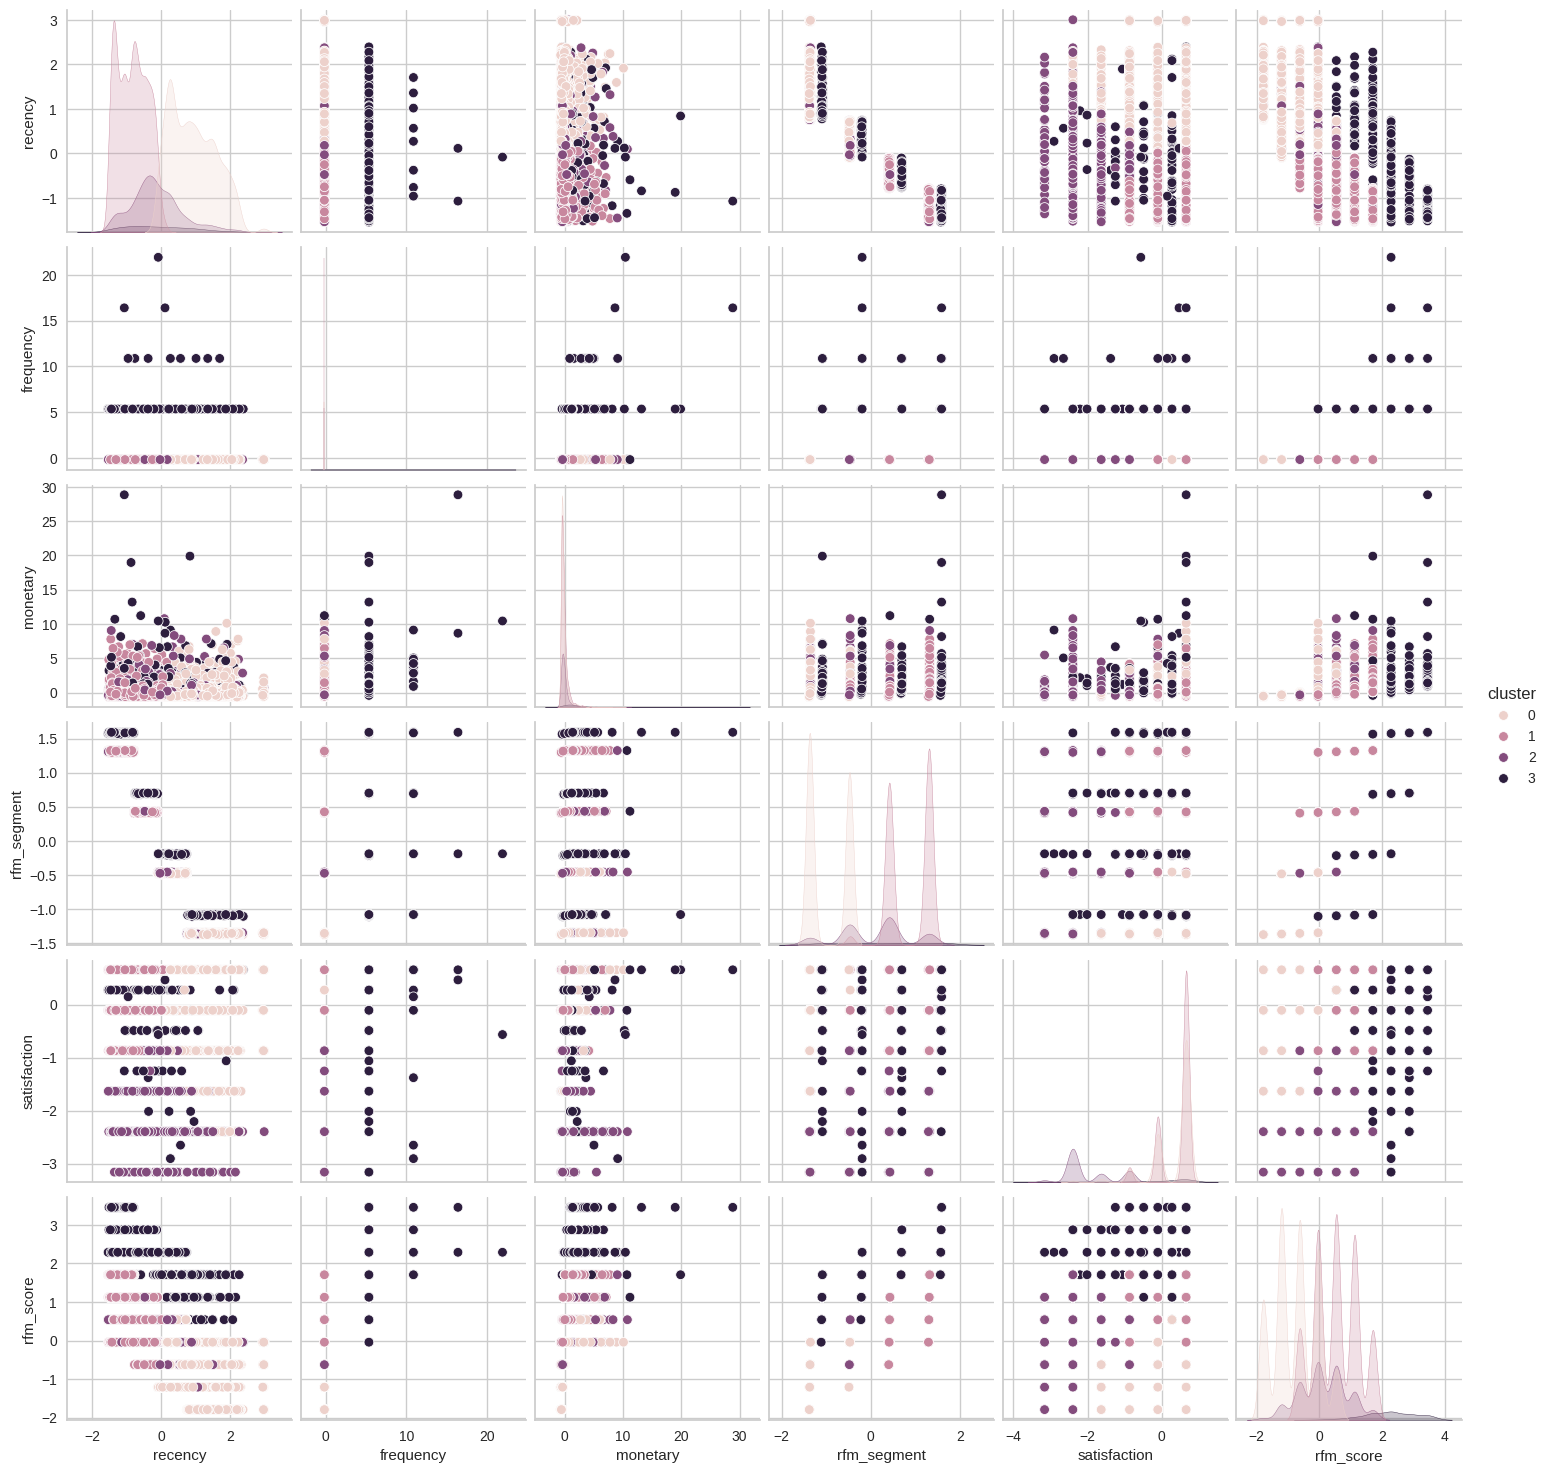

CPU times: user 22.6 s, sys: 523 ms, total: 23.1 s
Wall time: 22.3 s


In [15]:
%%time
kmeans = KMeans(n_clusters=best_silhouette_k, random_state=42).fit(first_selection_df)
labels = kmeans.labels_
first_selection_df["cluster"] = labels

sns.pairplot(first_selection_df, hue="cluster")
plt.show()

In [16]:
%%time
# Appliquer t-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(first_selection_df)
#X_tsne['Cluster'] = labels

CPU times: user 3min 3s, sys: 295 ms, total: 3min 3s
Wall time: 3min 3s


In [35]:
%%time
# Appliquer PCA pour réduire à 2 et 3 dimensions
pca_2d, X_pca_2d = get_pca(dim=2, selection='rfm', df=first_selection_df)
pca_3d, X_pca_3d = get_pca(dim=3, selection='rfm', df=first_selection_df)

print(f"Les trois dimensions capture {sum(pca_2d.explained_variance_ratio_ * 100)}")
print("-----"*9)
print(f"Les trois dimensions capture {sum(pca_3d.explained_variance_ratio_ * 100)}")
print("\n")

Les trois dimensions capture 68.91634483225693
---------------------------------------------
Les trois dimensions capture 86.97560705563473


CPU times: user 164 µs, sys: 30 µs, total: 194 µs
Wall time: 188 µs


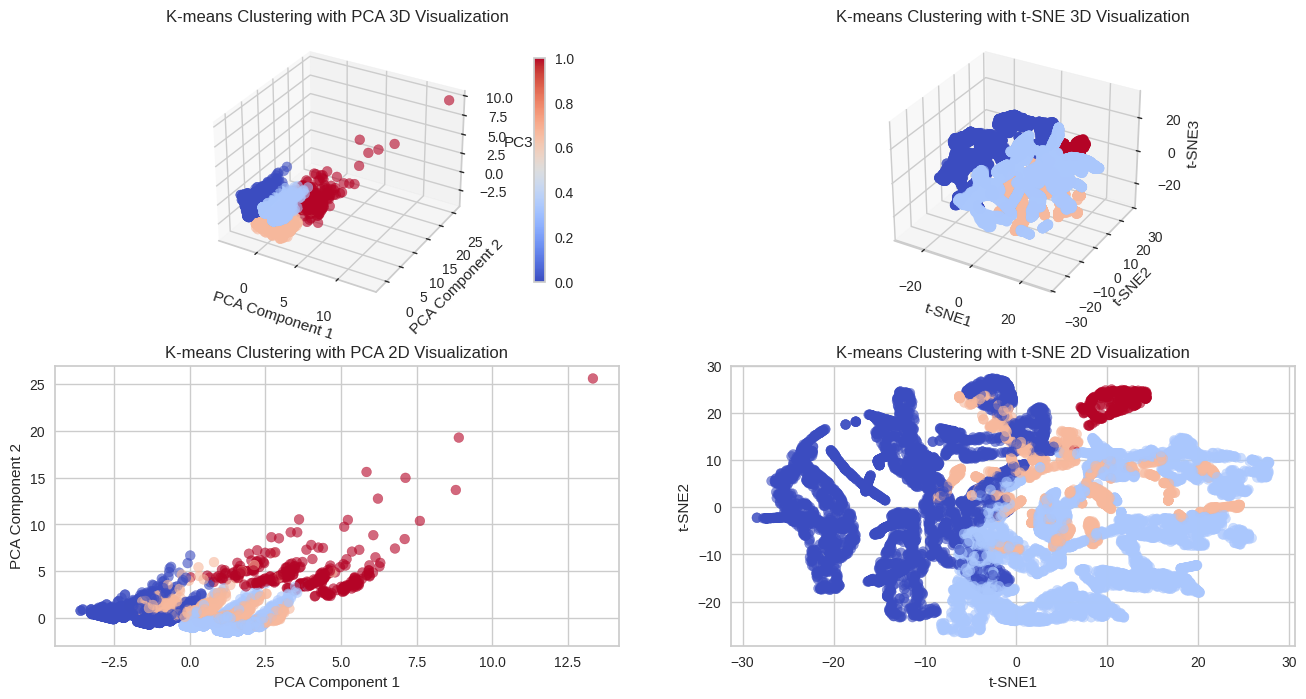

In [18]:
# Visualiser les résultats en 3D et 2D
plot_clusters(labels, X_pca, X_tsne)

## | 1.4 clustering avec l'ensemble des features

In [19]:
X = kmeans_data.copy()

### 1.4.1 | recherche du k optimal

In [20]:
%%time
silhouette_scores_2, dict_kmeans_2, best_silhouette_k_2 = find_best_k(X)

best_k=2, best_silhouette_k=0.6028022263814772
CPU times: user 21 s, sys: 6.65 s, total: 27.6 s
Wall time: 22 s


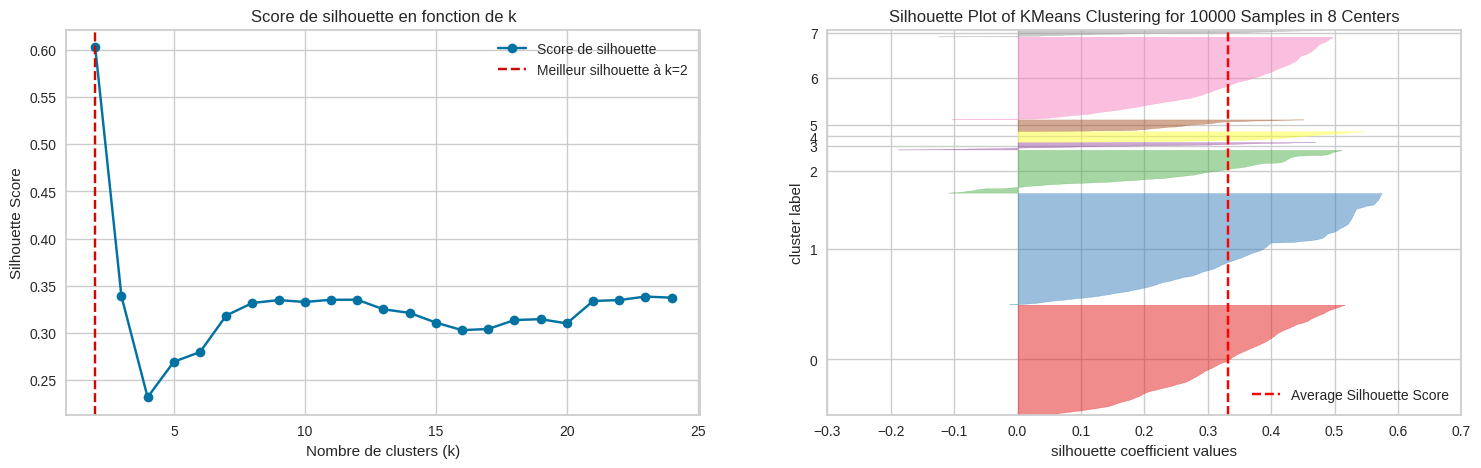

In [21]:
plot_silhouette_scores(X, silhouette_scores_2, best_silhouette_k_2)

### 1.4.2 | Kmean avec  k=2

In [22]:
%%time
kmeans_2 = KMeans(n_clusters=best_silhouette_k_2, random_state=42).fit(X)
labels_2 = kmeans_2.labels_

X_ = X.copy()
X_["cluster"] = labels

CPU times: user 11.8 ms, sys: 1.99 ms, total: 13.8 ms
Wall time: 12.1 ms


In [23]:
# Appliquer t-SNE pour réduire à 2 dimensions
tsne_2 = TSNE(n_components=3, random_state=0)
X_tsne_2 = tsne_2.fit_transform(X)

# Appliquer PCA pour réduire à 2 dimensions
pca_2 = PCA(n_components=3)
X_pca_2 = pca_2.fit_transform(X)

print(f"Les trois dimensions capture {sum(pca_2.explained_variance_ratio_ * 100)}")

Les trois dimensions capture 71.01677930670246


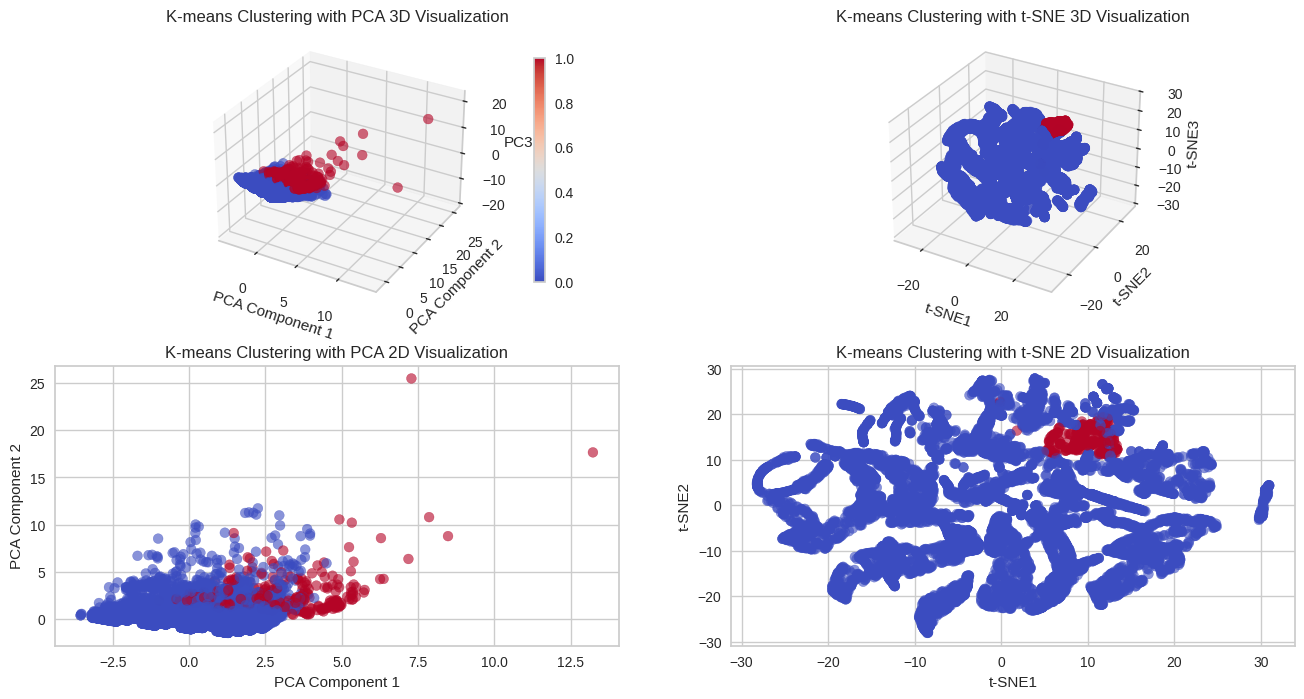

In [24]:
plot_clusters(labels_2, X_pca_2, X_tsne_2)

In [25]:
# Utilisation des radars plots pour une meilleure intrepretation des clusters

# 2 | DBscan Clustering

In [12]:
dbscan_sample = X_scaled.sample(10000, random_state=42).copy()

In [13]:
dbscan = DBSCAN(eps=1, min_samples=5)
labels_dbscan = dbscan.fit_predict(dbscan_sample)

In [14]:
plot_clusters(labels_dbscan)

<Figure size 1600x800 with 0 Axes>